In [27]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.interpolate import interp1d
from matplotlib import mlab

In [52]:

# https://www.gw-openscience.org/GW150914data/GW150914_tutorial.html

def whiten_wav(filename, output_file):
    # Load audio data from .wav file
    sample_rate, audio_data = wavfile.read(filename)
    audio_data = audio_data.astype(np.float64) # Make it a numpy Array of type float64

    fs = sample_rate
    NFFT = 1*fs

    pxx, freqs = mlab.psd(audio_data, Fs= fs, NFFT= NFFT)
    #TODO: poor noise reduction could come from value given to NFFT
    #NFFT = number of data points used in each block for the FFT. A power 2 is most efficient.

    interp_psd = interp1d(freqs, pxx)
    # PSD: Power spectral density, which describes how the power of a signal is distributed across different frequencies. Provides a way to represent the signal's frequency content.
    # In whitening, is used to scale the amplitudes of different frequency componenets

    dt = 1.0/ sample_rate # time resolution dt is the time interval between successive data points in the time series data

    # Normalize audio data by dividing it by the max absolute value of the data
    # This is to ensure that the data is within the range [-1, 1], which is required for proper whitening
    audio_data /= np.max(np.abs(audio_data))

    # Perform whitening on audio data
    # whitening: transform to freq domain, divide by asd, then transform back,
    # taking care to get normalization right
    Nt = len(audio_data)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(audio_data)

    # By dviding the frequency-domain representation of the data by the square root of the PSD function, the amplitudes of different frequency components are normalized, effectively flattening the frequency content of the data.
    white_hf = hf / (np.sqrt(interp_psd(freqs) / dt / 2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)

    # Saving result
    wavfile.write(output_file, sample_rate, white_ht)



In [57]:
def joint_plots(origen_file, destination_file):
    # Load audio file and apply FFT
    sample_rate, samples = wavfile.read(origen_file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    fft_values = np.fft.fft(samples)
    fig = plt.figure(figsize=(10, 12))

    # Plot time-domain representation of the audio signal
    ax1 = plt.subplot(311)
    ax1.plot(samples)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Signal value')
    ax1.set_title('Time-domain representation')
    ax1.grid()

    # Plot frequency-domain representation of the audio signal: how much each frequency is contributing to overall sound of audio file
    ax2 = plt.subplot(312)
    ax2.plot(abs(fft_values))
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Magnitude spectrum plot: Contribution of each frequency')
    ax2.grid()

    # Plot spectrogram of the audio signal
    ax3 = plt.subplot(313)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nfft=1024, nperseg=256)
    ax3.pcolormesh(times, frequencies, np.log10(spectrogram))
    ax3.set_title('Spectogram')
    ax3.set_ylabel('Frequency (Hz)')
    ax3.set_xlabel('Time (s)')
    #plt.colorbar()

    # Combine all the plots into a single figure
    plt.tight_layout()
    #plt.savefig(destination_file)
    plt.show()



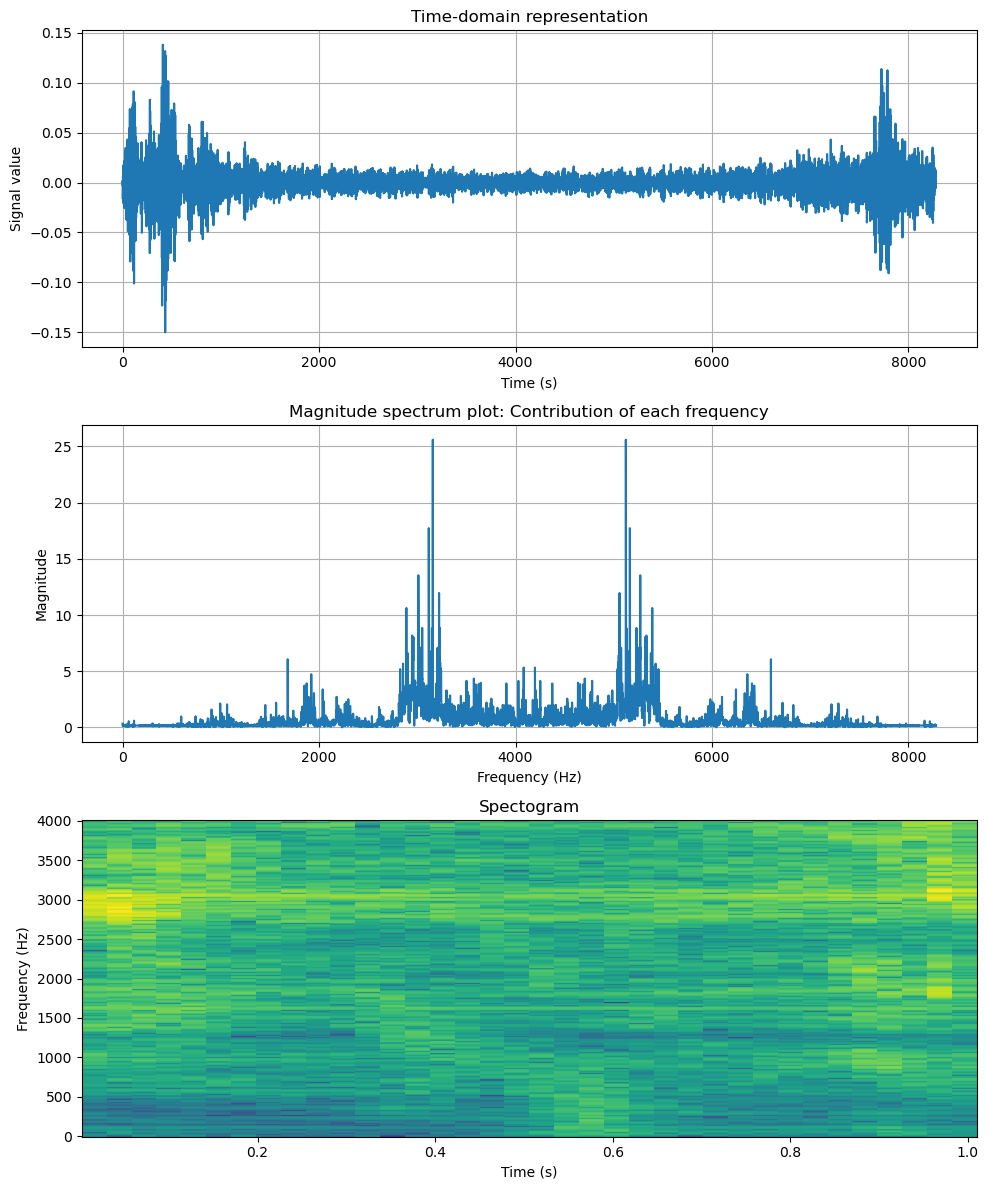

In [58]:

whiten_wav('data/Clips_denoised/gunshots/spectral_gating/ecoguns1.wav','whitened_audio_file.wav')
#whiten_wav('data/Clips/ecoguns1.wav','whitened_audio_file.wav')

joint_plots('whitened_audio_file.wav', 'whatever')